In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
h = sp.Symbol('h')
d = sp.Symbol('d')

In [3]:
def build_matrix(N, h, d):
    # Compute l[i] for i = 0 to N-1
    l = []
    for i in range(N):
        sum_term = sum((h*(1+d) - 1)**(-2 * k) for k in range(i + 1))
        l_i = (2 - h*(1+d)) / (h*(1+d) - 1) * sum_term                          # λ_i multiplier
        l.append(sp.simplify(l_i))

    b = []
    for i in range(N):
        multiplicator_term = 1/(h*(1+d)-1)**(1+2*i)
        b_i = h*d/2 * multiplicator_term                                        # b_i multiplier
        b.append(sp.simplify(b_i))

    C = []
    for i in range(1, N+1):
        C_i = ((1-h*(1+d))**(-2*i) - 1)/2
        C.append(sp.simplify(C_i))

    size = 2 * N + 1
    M = sp.zeros(size, size)

    for i in range(N):
        gi = i
        gip1 = i + 1
        di = N + 1 + i

        li = l[i]

        M[gi, gi] += 2 * (1 - h) * li - 2 * b[i] + 1
        val = (h - 2) * li - 1 + h
        M[gi, gip1] += val
        M[gip1, gi] += val

        val = -h * d * li
        M[gi, di] += val
        M[di, gi] += val

        M[gip1, gip1] += 2 * li + 1

        val = h * d * li + h * d
        M[gip1, di] += val
        M[di, gip1] += val

        M[di, di] += 2 * b[i]

    M[N, N] -= 2*C[N-1]

    return M

def is_psd(matrix, tol=1e-8):
    """
    Check if a SymPy matrix is positive semi-definite (PSD).

    Parameters:
        matrix (sp.Matrix): A SymPy matrix.
        tol (float): Tolerance for floating-point comparisons (used if matrix is numeric).
    
    Returns:
        bool: True if matrix is PSD, False otherwise.
    """
    if all(entry.is_number for entry in matrix):
        eigenvals = matrix.eigenvals()
        for eigval in eigenvals:
            if sp.re(eigval.evalf()) < -tol:
                return False
        return True


In [15]:
delta_levels = [0.1, 0.5, 0.8]
range_N = np.arange(1, 20, 1)
h_tilde_dict = {}

num_points = 200

for delta in delta_levels:
    h_range = np.linspace(2/(1+delta), 1.5/(1+delta), num_points)
    h_tilde = np.zeros(len(range_N))
    for i in range(len(range_N)):
        for j in range(len(h_range)):
            if not is_psd(build_matrix(int(range_N[i]), h_range[j], delta)):
                h_tilde[i] = h_range[j]
                break
        print("delta = {}: {}%".format(delta, 100*(i+1)/len(range_N)), end="\r")
    h_tilde_dict[delta] = h_tilde.copy()

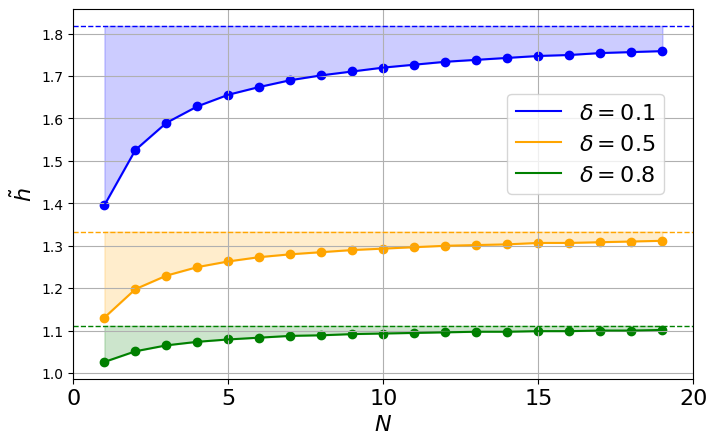

In [34]:
plt.figure(figsize=(8,4.8))

colors = ["blue", "orange", "green"]
for idx, delta in enumerate(delta_levels):
    plt.plot(range_N, h_tilde_dict[delta], label=f"$\\delta = {delta}$", color=colors[idx])
    plt.scatter(range_N, h_tilde_dict[delta], color=colors[idx])
    plt.axhline(2/(1+delta), color=colors[idx], linestyle="--", linewidth=1)
    plt.fill_between(range_N, h_tilde_dict[delta], 2/(1+delta), color=colors[idx], alpha=0.2)

plt.ylabel("$\\tilde{h}$", fontsize=16)
plt.xlabel("$N$", fontsize=16)
plt.xticks([0,5,10,15,20], fontsize=16)
plt.legend(loc = (0.7,0.5), fontsize=16)
plt.grid()
plt.savefig("../Images/tilde_h.pdf", bbox_inches = 'tight', transparent = True)